
### Física de la radioterapia
#### Máster de Física Biomédica. Universidad Complutense de Madrid
---
# **Problema**: Modelo de doble fuente en un acelerador lineal

#### Introducción
Para calcular la dosis debida a la radiación producida por un acelerador lineal, los algoritmos de cálculo necesitan conocer cómo varía la fluencia con el tamaño de campo.

En la práctica uno de los factores requeridos para este cálculo es el denominado factor de campo en minimaniquí $OF_0$, que se define como la lectura de una cámara de ionización colocada en el eje del campo en relación a la lectura obtenida para un campo de referencia.

Para evitar problemas de falta de equilibrio y contaminación electrónica, la cámara se coloca en el interior de un minimaniquí, que no introduce una contribución apreciable de radiación dispersada en el propio maniquí.




![Minimaniqui](https://drive.google.com/uc?id=14lGSvTekc8koyu_VzazMfNFh5iyC-CV9)

Aunque en condiciones ideales podríamos suponer que toda la radiación que incide sobre la cámara proviene de una fuente puntual, un foco de radiación formado en el lugar del blanco en el que son frenados los electrones, en la práctica se tiene que este foco no es puntual y que hay una contribución no despreciable de fotones que se han dispersado en los elementos del cabezal: colimador primario, filtro aplanador, cámaras monitoras y colimadores (mandíbulas y MLC).

Los sistemas de cálculo modelan el problema asumiendo la presencia de dos fuentes: una primaria, de mayor intensidad que se asocia a la emisión desde el blanco, y otra secundaria, menos intensa aunque de mayor extensión espacial, que modela la radiación que se ha dispersado en el cabezal.



<img src="https://drive.google.com/uc?id=1Os3ZS6JrYbnENEu2WP__XA3XLJYRHTQL" width="700" />

En este cuaderno desarrollaremos un modelo simplificado de doble fuente que nos permitirá explicar la forma de la curva de $OF_0$.

La distribución espacial de la intensidad de cada fuente según se observa en el punto de medida se describirá mediante una función con simetría cilíndrica de perfil gaussiano dependiente de dos parámetros $a$, $b$

\begin{equation}
    I(r) = a \cdot e^{-r^2/b}
\end{equation}

Durante el comisionado del acelerador, para medir $OF_0$ se retira el MLC y se varían las posiciones de las mandíbulas $X, Y$, generándose campos cuadrados y rectangulares.

Para sacar partido a la simetría cilíndrica de la fuente convendría utilizar campos circulares. Existen relaciones empíricas que relacionan los rendimientos en profundidad de campos circulares, cuadrados y rectangulares. Según estas un campo cuadrado es equivalente a un campo circular si ambos tienen la misma área y un campo rectangular es equivalente a uno cuadrado si ambos tienen la misma relación área perímetro. Si estas relaciones fueran aplicables también para $OF_0$, combinándolas se podría determinar el campo circular equivalente de cualquier campo cuadrado o rectangular.

### Objetivos
- Estudiar si las relaciones de equivalencia entre campos cuadrados y campos circulares y entre campos rectangulares y campos cuadrados son aplicables al factor de campo en aire $OF_0$ si la distribución espacial de la fluencia es de perfil gaussiano.
- Mostrar que no es posible ajustar las medidas de $OF_0$ mediante un modelo de una única fuente.
- Ajustar un modelo de doble fuente utilizando las medidas de $OF_0$ en campos cuadrados.

In [1]:
!pip install gdown

In [2]:
# Instalar paquetes no incluidos por defecto en Colab
# Ajustes no lineales mediante el algoritmo de Levenberg-Marquardt
!pip -q install lmfit
# Lectura de archivos Excel
!pip install -q openpyxl

# Importación de módulos y funciones
import gdown
import numpy as np
from scipy.special import erf
from scipy.interpolate import interp1d
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from lmfit import Model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.3 MB/s eta 0:00:00


### Cuestión
Considerando una única fuente comprobar la validez de la aproximación empírica que dice que un campo cuadrado y un campo circular tienen el mismo factor de campo si ambos tienen la misma área.

### Solución
El factor de campo es independiente de la intensidad absoluta de la fuente y por tanto es independiente de $a$.

El factor de campo es proporcional a la integral de la intensidad de la fuente. Para campos circulares

$$
  OF_0(R) \propto \int_0^{2\pi}\int_0^R r \cdot e^{-r^2/b} dr d\theta = b\pi\left( 1-e^{-R^2/b} \right)
$$

Para campos cuadrados

$$
  OF_0(X) \propto \int_0^X \int_0^Xe^{-(x^2+y^2)/b} dx dy = \left(\int_0^X e^{-x^2/b}
   dx \right)^2 = \frac{b\pi}{4} \operatorname{erf}^2\left(\frac{X}{\sqrt{b}}\right)
$$

donde $X$ corresponde al hemicampo, lo que se desplaza cada mordaza desde el origen. El lado del campo cuadrado sería $L=2X$ y por tanto la relación de equivalencia entre campos cuadrados y circulares por igualdad de área implica la siguiente relación entre $X$ y $R$

$$
  4X^2 = \pi R^2
$$

$$
  X = \frac{\sqrt{\pi}}{2} R \approx 0.886 R
$$

Implementamos las funciones para el cálculo del factor de campo. Como el factor de campo es una medida relativa podemos eliminar las constantes de proporcionalidad, solo nos interesa la dependencia con el tamaño de campo. El parámetro $b$ por su parte, actúa como un factor de escala del tamaño de la fuente y del tamaño de los campos. Determina para qué tamaños de campo se produce el crecimiento del factor de campo hasta la saturación, pero tampoco es relevante para esta discusión. Lo fijamos en $b=1$.

In [4]:
def OF_0_circ(R, b=1):
  '''
  Factor de campo en aire para campos circulares
  Parámetros:
    R: Radio del campo circular
    b: Parámetro que regula el tamaño de la fuente
  '''
  return 1 - np.exp(-R**2/b)

def OF_0_sq(X, b=1):
  '''
  Factor de campo en aire para campos cuadrados
  Parámetros:
    X: Tamaño del campo cuadrado
    b: Parámetro que regula el tamaño de la fuente
  '''
  return erf(X/np.sqrt(b))**2

Muestreamos y representamos los dos factores de campo.

Para comprobar la equivalencia tenemos que elegir campos con la misma área

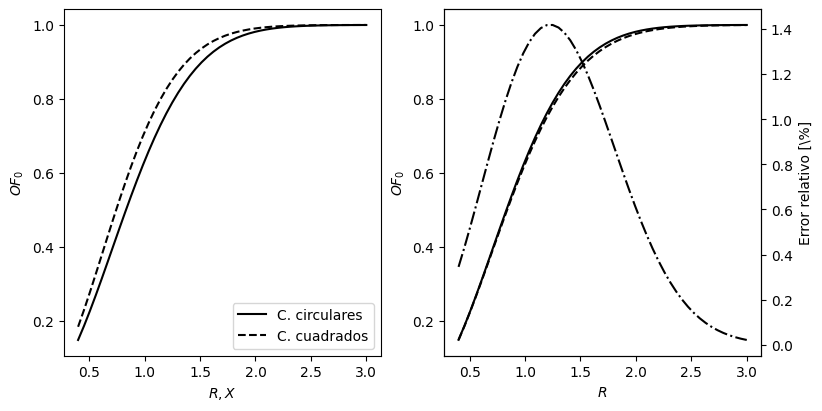

In [5]:
# Muestra de radios
Rs = np.linspace(0.4, 3, 50)

# Muestra de campos cuadrados
Xs = np.linspace(0.4, 3, 50)

# Factor de equivalencia entre R (campos circulares) y X (campos cuadrados)
Feq = np.sqrt(np.pi)/2

# Representar
fig, (axl, axr) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4.5))
# En el gráfico de la izquierda representamos los factores de campo en función
# de sus dimensiones naturales
axl.plot(Rs, OF_0_circ(Rs), 'k-', label='C. circulares')
axl.plot(Xs, OF_0_sq(Xs), 'k--', label='C. cuadrados')
axl.set_xlabel('$R, X$')
axl.set_ylabel(r'$OF_0$')
axl.legend()
# En el gráfico de la derecha escalamos el hemicampo cuadrado a su equivalente
# circular
axr.plot(Rs, OF_0_circ(Rs), 'k-', label='C. circulares')
axr.plot(Rs, OF_0_sq(Rs*Feq), 'k--', label='C. cuadrados')
axr.set_xlabel('$R$')
axr.set_ylabel(r'$OF_0$')
# Añadimos un gráfico para representar el error relativo de la aproximación
axrt = axr.twinx()

axrt.plot(Rs, (OF_0_circ(Rs) / OF_0_sq(Rs*Feq)-1)*100, 'k-.')
axrt.set_ylabel(r'Error relativo [\%]')
# axrt.set_ylim(0.998, 1.02)

plt.show()

En la gráfica de la izquierda hemos representado el factor de campo $OF_0$ según las expresiones analíticas calculadas de la integral de la fluencia gaussiana para campos circulares en función del radio $R$ y para campos cuadrados en función del hemicampo $X$.

Para comprobar la equivalencia de los campos hemos representado en la gráfica de la derecha ambos factores de campo en función del radio $R$ escalando para los campos cuadrados el valor del hemicampo $X$ por la expresión que se deriva de la igualdad de áreas.

El error relativo entre ambos factores de campo es del orden del 1%, concluyéndose que la aproximación es razonablemente ajustada.

### Cuestión

Considerando una única fuente comprobar la validez de la aproximación empírica que dice que un campo cuadrado y un campo rectangular tienen el mismo factor de campo si ambos tienen la misma relación área perímetro.

### Solución

Para campos rectangulares

$$
  OF_0(X, Y) \propto \int_0^Y \int_0^Xe^{-(x^2+y^2)/b} dx dy = \left(\int_0^X e^{-x^2/b}
  dx \right)\cdot \left(\int_0^Y e^{-y^2/b}
  dy \right)= \frac{b\pi}{4} \operatorname{erf}\left(\frac{X}{\sqrt{b}}\right)\cdot\operatorname{erf}\left(\frac{Y}{\sqrt{b}}\right)
$$

donde $X, Y$ corresponden al hemicampo, lo que se desplaza cada mordaza desde el origen.

De la igualdad de la relación área perímetro podemos determinar el valor del hemicampo $X_c$ del campo cuadrado equivalente al campo rectangular con hemicampos $X, Y$

$$
  X_c = \frac{2\cdot X\cdot Y}{X+Y}
$$

Por tanto lo que queremos comprobar es si

$$
  \operatorname{erf}\left(\frac{X}{\sqrt{b}}\right)\cdot\operatorname{erf}\left(\frac{Y}{\sqrt{b}}\right) = \operatorname{erf}^2\left(\frac{2\cdot X\cdot Y}{\sqrt{b}\cdot(X+Y)}\right)
$$

Lo mismo que antes, el resultado no depende del valor de $b$ y lo igualaremos a 1.

Implementamos la función de $OF_0$ para campos rectangulares y comparamos el resultado con su campo cuadrado equivalente

In [6]:
def OF_0_rect(X, Y, b=1):
  '''
  Factor de campo en aire para campos cuadrados
  Parámetros:
    X: Mordaza X del hemicampo del campo rectangular
    Y: Mordaza Y del hemicampo del campo rectangular
    b: Parámetro que regula el tamaño de la fuente
  '''
  return erf(X/np.sqrt(b))*erf(Y/np.sqrt(b))

def X_c(X, Y):
  '''
  Tamaño del campo cuadrado equivalente para campos rectangulares
  Parámetros:
    X: Mordaza X del hemicampo del campo rectangular
    Y: Mordaza Y del hemicampo del campo rectangular
  '''
  return 2*X*Y/(X+Y)

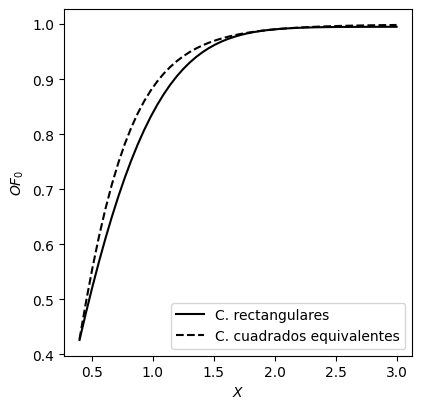

In [7]:
# Muestras de los hemicampos para campos rectangulares
Ys = np.array([2])
Xs = np.linspace(0.4, 3, 50)

# Hemicampos de los campos cuadrados equivalentes
Xcs = X_c(Xs, Ys)

# Representar
fig, (axl) = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
# En el gráfico de la izquierda representamos los factores de campo en función
# de sus dimensiones naturales
axl.plot(Xs, OF_0_rect(Xs, Ys), 'k-', label='C. rectangulares')
axl.plot(Xs, OF_0_sq(Xcs), 'k--', label='C. cuadrados equivalentes')
axl.set_xlabel(r'$X$')
axl.set_ylabel(r'$OF_0$')
axl.legend()

plt.show()

Las curvas anteriores muestran que la equivalencia a campos cuadrados para campos rectangulares basada en mantener la relación área perímetro no es válida.

Podemos dudar si esto se debe a que el modelo de fuente de perfil gaussiano no describe adecuadamente la fuente real.

### Cuestión

Utilizar los datos reales medidos en un acelerador Varian True Beam para mostrar que la aproximación no es suficientemente buena.

#### Ayuda
Crear una función de interpolación de los factores de campo cuadrados para calcular el factor de campo del campo equivalente de cada campo rectangular. Comparar con los valores medidos.

In [8]:
# Descargar los datos compartidos de Google Drive
url = 'https://docs.google.com/uc?id=1QbmB_WbXYd6QOaaEedfRSQoyp21ZNRf6'
#
output = './AirOutputFactors.xlsx'
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1QbmB_WbXYd6QOaaEedfRSQoyp21ZNRf6
To: /content/AirOutputFactors.xlsx
100%|██████████| 32.7k/32.7k [00:00<00:00, 34.1MB/s]


'./AirOutputFactors.xlsx'

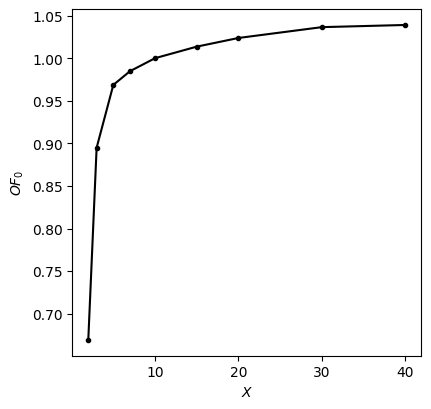

In [9]:
# Leer los datos de los factores de campo para la energía de 6 MV
OF_0_6X_df = pd.read_excel('AirOutputFactors.xlsx', sheet_name='6MV', skiprows=36, engine='openpyxl')
# Extraer los factores de campo para campos cuadrados
OF_0_6X_sqs = np.diag(OF_0_6X_df[OF_0_6X_df.columns[1:]])
# Tamaños de campo cuadrados
Xs = np.array(OF_0_6X_df.Y)

# Representamos gráficamente
fig, ax = plt.subplots(figsize=(4.5, 4.5))
ax.plot(Xs, OF_0_6X_sqs, 'k.-')
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$OF_0$')

plt.show()

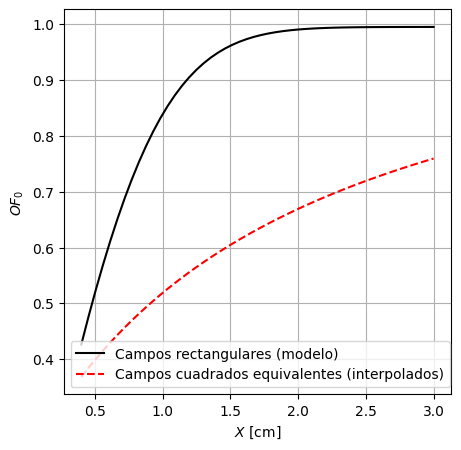

In [17]:
# Definimos una función de interpolación para los factores de campo cuadrados
interp_OF_0 = interp1d(Xs, OF_0_6X_sqs, kind='linear', fill_value='extrapolate')

# Generamos algunas dimensiones de campo cuadrado equivalente y sus correspondientes
Ys = np.array([2])  #Fijamos Y = 2
Xs_test = np.linspace(0.4, 3, 50)  #Variamos X de 0.4 a 3
Xcs = X_c(Xs_test, Ys)
# factores de campo interpolados
OF_0_Xcs = interp_OF_0(Xcs)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(Xs_test, OF_0_rect(Xs_test, Ys), 'k-', label='Campos rectangulares (modelo)')
ax.plot(Xs_test, OF_0_Xcs, 'r--', label='Campos cuadrados equivalentes (interpolados)')
ax.set_xlabel(r'$X$ [cm]')
ax.set_ylabel(r'$OF_0$')
ax.legend()
plt.grid(True)
plt.show()

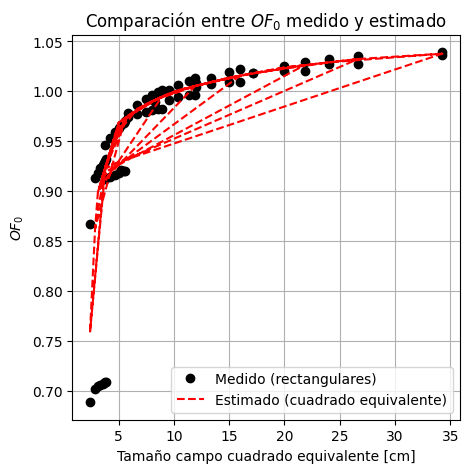

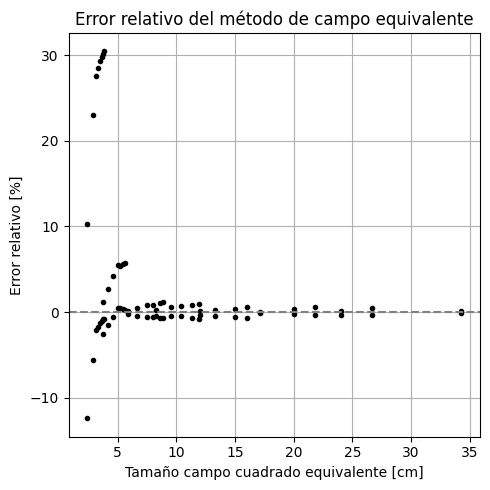

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Cargar datos desde Excel
OF_0_6X_df = pd.read_excel('AirOutputFactors.xlsx', sheet_name='6MV', skiprows=36, engine='openpyxl')
Y_vals = OF_0_6X_df['Y'].values
X_labels = OF_0_6X_df.columns[1:]

# Obtener tamaños de campos cuadrados y sus factores de campo
square_sizes = [int(x[1:]) for x in X_labels]
OF_0_6X_sqs = np.diag(OF_0_6X_df[X_labels])

# Interpolación lineal sobre campos cuadrados
interp_OF_0 = interp1d(square_sizes, OF_0_6X_sqs, kind='linear', fill_value='extrapolate')

# Extraer campos rectangulares y sus medidas reales
rect_X, rect_Y, OF_0_real = [], [], []

for i, Y in enumerate(Y_vals):
    for j, label in enumerate(X_labels):
        X = int(label[1:])
        val = OF_0_6X_df.iloc[i, j + 1]
        if not pd.isna(val) and X != Y:  # Solo rectangulares
            rect_X.append(X / 2)
            rect_Y.append(Y / 2)
            OF_0_real.append(val)

rect_X = np.array(rect_X)
rect_Y = np.array(rect_Y)
OF_0_real = np.array(OF_0_real)

# Función de campo cuadrado equivalente
def X_c(X, Y):
    return 2 * X * Y / (X + Y)

Xceq = X_c(rect_X, rect_Y)
OF_0_est = interp_OF_0(Xceq * 2)

# === Gráfica 1: Comparación entre OF0 medido y estimado ===
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(Xceq * 2, OF_0_real, 'ko', label='Medido (rectangulares)')
ax.plot(Xceq * 2, OF_0_est, 'ro', label='Estimado (cuadrado equivalente)')
ax.set_xlabel('Tamaño campo cuadrado equivalente [cm]')
ax.set_ylabel(r'$OF_0$')
ax.set_title('Comparación entre $OF_0$ medido y estimado')
ax.legend()
ax.grid(True)




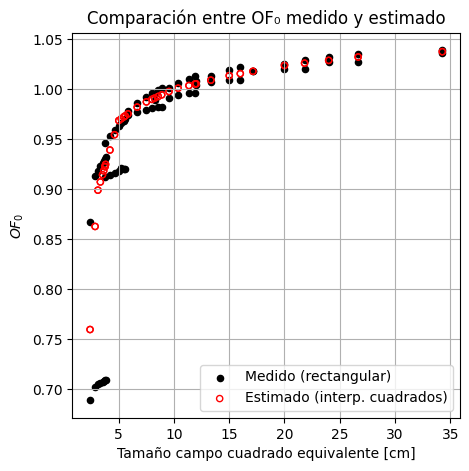

In [13]:
OF_0_6X_df = pd.read_excel('AirOutputFactors.xlsx', sheet_name='6MV', skiprows=36, engine='openpyxl')
Y_vals = OF_0_6X_df['Y'].values
X_labels = OF_0_6X_df.columns[1:]

square_sizes = [int(x[1:]) for x in X_labels]
OF_0_6X_sqs = np.diag(OF_0_6X_df[X_labels])

fun_interp = interp1d(square_sizes, OF_0_6X_sqs, kind='linear', fill_value='extrapolate')

rect_X, rect_Y, OF_0_real = [], [], []

for i, Y in enumerate(Y_vals):
    for j, label in enumerate(X_labels):
        X = int(label[1:])
        val = OF_0_6X_df.iloc[i, j + 1]
        if not pd.isna(val) and X != Y:
            rect_X.append(X / 2)
            rect_Y.append(Y / 2)
            OF_0_real.append(val)

rect_X = np.array(rect_X)
rect_Y = np.array(rect_Y)
OF_0_real = np.array(OF_0_real)

def X_c(X, Y):
    return 2 * X * Y / (X + Y)

Xceq = X_c(rect_X, rect_Y)
OF_0_est = fun_interp(Xceq * 2)

# Comparación de los valores reales con los estimados
fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.scatter(Xceq*2, OF_0_real, color='black', label='Medido (rectangular)', s=20)
ax1.scatter(Xceq*2, OF_0_est, facecolors='none', edgecolors='red', label='Estimado (interp. cuadrados)', s=20, marker='o')
ax1.set_xlabel('Tamaño campo cuadrado equivalente [cm]')
ax1.set_ylabel(r'$OF_0$')
ax1.set_title('Comparación entre OF₀ medido y estimado')
ax1.grid(True)
ax1.legend()




Vemos en la gráfica de la comparación que los valores, especialmente a partir de 2.5 cm aproximadamente, los valores medidos y estimados coinciden bastante.

También con el error relativo se ve que, aunque no es una estimación perfeta, es fundamentalmente significativo para valores pequeños de campo cuadrado equivalente. Esto puede ser debido a la sensibilidad de $OF_0$, ya que cambia mucho con pequeñas variaciones en tamaño. También puede ser debido a que el método de campo cuadrado equivalente no valora la forma real del perfil de dosis ni la dispersión lateral del haz, lo cual funciona bien para campos grandes o moderados, pero peor para campos pequeños.

En resumen, la aproximación no es lo suficientemente buena al completo.

### Cuestión
Mostrar que no es posible ajustar las medidas mediante un modelo de una única fuente

El modelo de la única fuente asume que la distribución de intensidad es igual en todas las direcciones y que la intensidad varía sin saltos bruscos. Sin embargo, la realidad tiene muchos más efectos, entonces a continuación estudiaremos por que no es suficiente este modelo.

Para ello construiremos modelo teórico basado en el de única fuente, calcularemos los factores de campo teórico y compararemos los resultados con los reales:

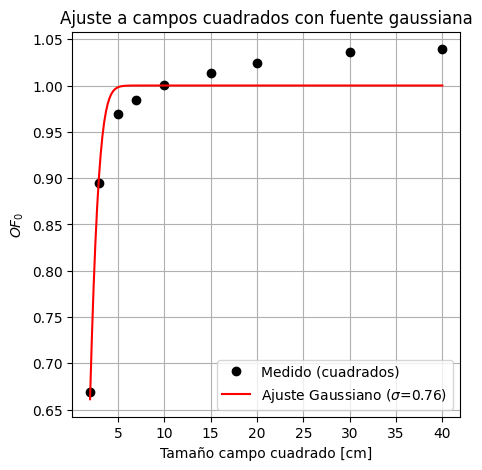

In [18]:
from scipy.optimize import curve_fit
from scipy.special import erf
import numpy as np
import matplotlib.pyplot as plt

# Datos de campos cuadrados (tamaño en cm y OF medido)
Xs_cm = square_sizes
OF_sqs = OF_0_6X_sqs

# Modelo de una única fuente gaussiana
def modelo_fuente_unica(x, sigma):
    x = np.array(x) / 2  # hemicampos
    return (erf(x / (np.sqrt(2) * sigma)))**2

# Ajuste del modelo a los datos cuadrados
popt, _ = curve_fit(modelo_fuente_unica, Xs_cm, OF_sqs, p0=[1.5])  # p0 es la estimación inicial de sigma
sigma_opt = popt[0]

# Comprobamos el ajuste para campos cuadrados
Xs_fit = np.linspace(min(Xs_cm), max(Xs_cm), 200)
OF_fit = modelo_fuente_unica(Xs_fit, sigma_opt)

plt.figure(figsize=(5, 5))
plt.plot(Xs_cm, OF_sqs, 'ko', label='Medido (cuadrados)')
plt.plot(Xs_fit, OF_fit, 'r-', label=f'Ajuste Gaussiano ($\sigma$={sigma_opt:.2f})')
plt.xlabel('Tamaño campo cuadrado [cm]')
plt.ylabel(r'$OF_0$')
plt.title('Ajuste a campos cuadrados con fuente gaussiana')
plt.grid(True)
plt.legend()
plt.show()


Vemos que efectivamente el modelo de única fuente no es un buen modelo para ajustarse a los valores medidos.

### Cuestión

Ajustar las medidas del factor de campo en aire $OF_0$ para campos cuadrados mediante un modelo de doble fuente basado en cuatro parámetros utilizando la aproximación de campos circulares equivalentes

$$
  OF_0(L) = I_1\cdot \left(1-e^{-L^2/b_1}\right) + I_2\cdot \left(1-e^{-L^2/b_2}\right)
$$

donde $L$ es el lado del campo cuadrado, $I_1$ la intensidad de la fuente primaria, $b_1$ un parámetro relacionado con el tamaño de la fuente primaria, $I_2$ la intensidad de la fuente secundaria, $b_2$ un parámetro relacionado con el tamaño de la fuente secundaria.

#### Ayuda

Para realizar los ajustes se recomienda utilizar el paquete [lmfit](https://lmfit.github.io/lmfit-py/)
(Non-Linear Least-Squares Minimization and Curve-Fitting for Python) una interfaz de alto nivel para resolver problemas de ajuste de curvas y optimización no lineal en python. Su uso básico es relativamente simple. Basta con definir la función de ajuste con sus variables independientes y los parámetros de ajuste también como variables. A partir de esta función se crea un **modelo** de ajuste como una instancia de la clase `Model`. Este objeto tiene todos los métodos para realizar el ajuste y evaluar el resultado. Los parámetros del modelo se pueden introducir directamente o creando una instancia del objeto 'Parameters' si se necesita tener más control sobre ellos.

In [20]:
from lmfit import Model, Parameters

#### Modelo de doble fuente

In [21]:
def OF_0_2src_f(L, I1, b1, I2, b2):
  '''
  Función que representa el factor de campo en aire para campos cuadrados
  L: lado del campo cuadrado
  I1: intensidad de la fuente primaria
  b1: parámetro relacionado con el tamaño de la fuente primaria
  I2: intensidad de la fuente secundaria
  b2: parámetro relacionado con el tamaño de la fuente secundaria
  '''
  return I1 * (1 - np.exp(-L**2 / b1)) + I2 * (1 - np.exp(-L**2 / b2))

double_source_model = Model(OF_0_2src_f)

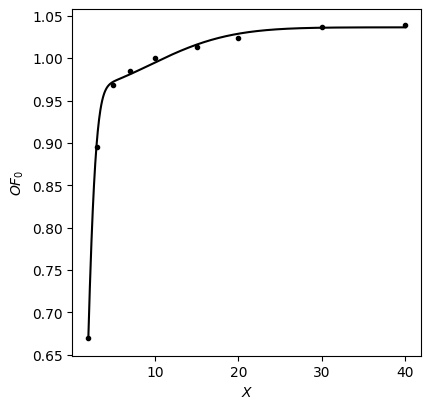

In [22]:
# Ajustamos. Introducimos los parámetros directamente dando un valor inicial
double_source_result = double_source_model.fit(OF_0_6X_sqs, L=OF_0_6X_df.Y, I1=0.9, b1=2, I2=0.1, b2=20)

# Obtenemos la función de ajuste particularizada para nuestros parámetros de ajuste
def OF_0_2src_sq_fit(L):
  return double_source_model.eval(double_source_result.params, L=L)

# Valores de X con mayor densidad para la gráfica del ajuste
Xis = np.linspace(Xs[0], Xs[-1], 1000)

# Representamos gráficamente
fig, ax = plt.subplots(figsize=(4.5, 4.5))
ax.plot(Xs, OF_0_6X_sqs, 'k.')
ax.plot(Xis, OF_0_2src_sq_fit(L=Xis), 'k-')
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$OF_0$')

double_source_result


### Cuestión

Estudiar cuál de los siguientes modelos describe mejor los $OF_0$ para campos cuadrados.

Para realizar el ajuste utilizar solo los datos de $OF_0$ medidos en 6 MV `OF_0_6X_sqs` de campos cuadrados de lado `Xs`

#### Modelo de doble fuente con distinción de $X, Y$

$$
  OF_0(X,Y,I_1,I_2,s,t,u,v) = I_1\cdot \operatorname{erf}\left(\frac{X}{s}\right)\cdot\operatorname{erf}\left(\frac{Y}{t}\right) + I_2\cdot \operatorname{erf}\left(\frac{X}{u}\right)\cdot\operatorname{erf}\left(\frac{Y}{v}\right)
$$

Este modelo considera dos fuentes gaussianas de distinto tamaño efectivo. Además se considera que el tamaño de cada fuente visto desde el punto de medida cambia por la diferente distancia entre cada par de mordazas y la fuente.

#### Modelo de doble fuente con distinción de $X, Y$ para la segunda fuente

$$
  OF_0(X,Y,I_1,I_2,s,t,u) = I_1\cdot \operatorname{erf}\left(\frac{X}{s}\right)\cdot\operatorname{erf}\left(\frac{Y}{s}\right) + I_2\cdot \operatorname{erf}\left(\frac{X}{t}\right)\cdot\operatorname{erf}\left(\frac{Y}{u}\right)
$$

Aquí se consideran dos fuentes gaussianas de diferente tamaño, pero el efecto de la distancia a cada par de mordazas solo afecta apreciablemente a la fuente secundaria por ser la que está más cerca de estas.

- Considerando la regularización del modelo, ¿cuál de los dos modelos es más adecuado para el ajuste?
- Centrándonos en el modelo más adecuado, existe algún parámetro que se haya determinado con una incertidumbre inasumible.
- **Avanzado**: ¿De dónde proviene esa incertidumbre si aparentemente los resultados del modelo son buenos? Proponer alguna regularización adicional que reduzca la incertidumbre del parámetro.